In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings('ignore')

In [17]:
data1 = pd.read_csv('/kaggle/input/youtube-spam-classifiedcomments/Youtube01-Psy.csv')
data2 = pd.read_csv('/kaggle/input/youtube-spam-classifiedcomments/Youtube02-KatyPerry.csv')
data3 = pd.read_csv('/kaggle/input/youtube-spam-classifiedcomments/Youtube03-LMFAO.csv')
data4 = pd.read_csv('/kaggle/input/youtube-spam-classifiedcomments/Youtube04-Eminem.csv')
data5 = pd.read_csv('/kaggle/input/youtube-spam-classifiedcomments/Youtube05-Shakira.csv')


In [26]:
data = pd.concat([data1, data2, data3, data4, data5])
data.drop_duplicates()
data.reset_index()
data.shape

(1956, 5)

In [27]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [34]:
data['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [37]:
data.isna().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

# Function to convert words into tokens

In [43]:
def get_sequences(texts, tokenizer, train = True, max_seq_len = None):
    sequence = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_len = np.max(list(map(len, sequence)))
    sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen = max_seq_len, padding = 'post')
    return sequence

In [48]:
def preprocessing(df):
    df = df.copy()
    # Splitting Data
    X = df['CONTENT']
    Y = df['CLASS']
    # Train_Test_Split
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, shuffle = True, random_state = 1)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train)
    print(f'Vocab Length : {len(tokenizer.word_index)+1}')
    x_train = get_sequences(texts = x_train, tokenizer = tokenizer, train = True)
    x_test = get_sequences(texts = x_test, tokenizer = tokenizer, train = False, max_seq_len = x_train.shape[1])
    print(f'\nSequence Length : {x_train.shape[1]}')
    return x_train, x_test, y_train, y_test

In [49]:
x_train, x_test, y_train, y_test = preprocessing(data)

Vocab Length : 3821

Sequence Length : 227


# Training

In [54]:
inputs = tf.keras.Input(shape = (227,))
x = tf.keras.layers.Embedding(input_dim = 3821, output_dim = 300)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128 , activation = 'relu')(x)
x = tf.keras.layers.Dense(128 , activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 227)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 227, 300)          1146300   
_________________________________________________________________
flatten_4 (Flatten)          (None, 68100)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8716928   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 9,879,869
Trainable params: 9,879,869
Non-trainable params: 0
_________________________________________________

In [55]:
history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ]
)

2022-12-15 05:53:58.978388: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
35/35 [==============================] - 3s 66ms/step - loss: 0.7004 - accuracy: 0.5973 - auc: 0.6392 - val_loss: 0.5020 - val_accuracy: 0.8029 - val_auc: 0.9127
Epoch 2/100
35/35 [==============================] - 2s 54ms/step - loss: 0.3125 - accuracy: 0.9068 - auc: 0.9626 - val_loss: 0.2098 - val_accuracy: 0.9051 - val_auc: 0.9881
Epoch 3/100
35/35 [==============================] - 2s 55ms/step - loss: 0.0991 - accuracy: 0.9635 - auc: 0.9948 - val_loss: 0.1487 - val_accuracy: 0.9489 - val_auc: 0.9848
Epoch 4/100
35/35 [==============================] - 2s 56ms/step - loss: 0.0373 - accuracy: 0.9918 - auc: 0.9985 - val_loss: 0.1445 - val_accuracy: 0.9489 - val_auc: 0.9854
Epoch 5/100
35/35 [==============================] - 2s 57ms/step - loss: 0.0141 - accuracy: 0.9973 - auc: 0.9999 - val_loss: 0.1541 - val_accuracy: 0.9489 - val_auc: 0.9850
Epoch 6/100
35/35 [==============================] - 2s 56ms/step - loss: 0.0082 - accuracy: 0.9982 - auc: 1.0000 - val_loss: 0.16

Results

In [56]:
results = model.evaluate(x_test, y_test, verbose = 0)
print(f'Accuracy : {round(results[1]*100, 4)}%')
print(f'AUC : {round(results[2],3)}')

Accuracy : 92.6746%
AUC : 0.973


Confusion Matrix and Classifcation Report

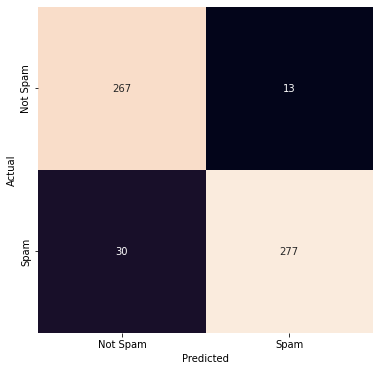

Classification Report ------------------->
              precision    recall  f1-score   support

    Not Spam       0.90      0.95      0.93       280
        Spam       0.96      0.90      0.93       307

    accuracy                           0.93       587
   macro avg       0.93      0.93      0.93       587
weighted avg       0.93      0.93      0.93       587



In [57]:
y_pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred,labels = [0,1] )
clr = classification_report(y_test, y_pred, labels = [0,1], target_names = ['Not Spam', "Spam"])
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Not Spam', "Spam"])
plt.yticks(ticks = [0.5, 1.5], labels = ['Not Spam', "Spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Classification Report ------------------->\n{clr}')